# (t, n) Sharing Scheme

## Finding inverse of a general (Ax + b) mod N 

In [1]:
# Defining the randomizer equation as A(x + b) mod N
def randomizer(x, A, b, c, d, i, j, N):
    return (A * (x + b + c*i + d*i + i*j)) % N

# Finding the inverse of the randomizer equation as A^-1*x - b mod N
def inverse_randomizer(y, A_inv, b, c, d, i, j, N):
    return (A_inv * y - b - c*i - d*i - i*j) % N

def modinv(a, n):
    t, new_t = 0, 1
    r, new_r = n, a
    while new_r != 0:
        quotient = r // new_r
        t, new_t = new_t, t - quotient * new_t
        r, new_r = new_r, r - quotient * new_r
    if r > 1:
        return None  # no inverse exists
    return t % n

### Exaple Usage of this randomizer function along with its inverse

In [2]:
# Example
A = 314
b = 15
c = 153
d = 203
i = 2
j = 3
N = 255
A_inv = modinv(A, N)
if A_inv is None:
    raise ValueError("Inverse does not exist")

# Original pixel value
x = 202

# Randomized pixel value
y = randomizer(x, A, b, c, d, i, j, N)

print(f"Original pixel value: {x}")
print(f"Randomized pixel value: {y}")

# Inverse randomized pixel value
x_inv = inverse_randomizer(y, A_inv, b, c, d, i, j, N)
print(f"Inverse randomized pixel value: {x_inv}")

Original pixel value: 202
Randomized pixel value: 85
Inverse randomized pixel value: 202


## Encrypting an Image using this function

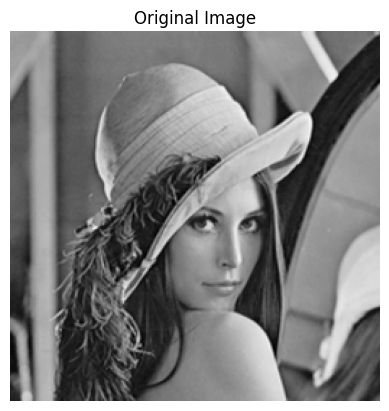

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import measure


# Load the original image in grayscale
image = Image.open('lena.png')
image = image.convert('L')
image = np.array(image).astype(np.uint64)

# Plotting original image
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

# TODO: Compressing Using Huffman Encoding   
# data = np.array(image).flatten().tolist()
# dynamic_huffman = DynamicHuffman()
# encoded_data = dynamic_huffman.encode(data)
# print(f"Encoded Data Length: {len(encoded_data)} bits")
# original_size = len(data) * 8 
# compressed_size = len(encoded_data) 
# compression_ratio = compressed_size / original_size
# print(f"Compression Ratio: {compression_ratio:.2f}")

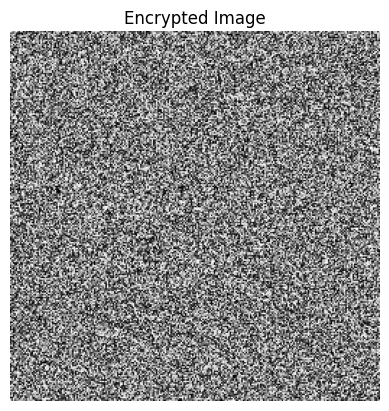

In [4]:
# Encrypting the image using the randomizer equation
A = 314
b = 15
c = 153
d = 203
N = 255
A_inv = modinv(A, N)
if A_inv is None:
    raise ValueError("Inverse does not exist")

# Encrypt the image using the randomizer equation
encrypted_image = np.zeros_like(image, dtype=np.uint32)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        encrypted_image[i, j] = randomizer(image[i, j], A, b, c, d, i, j, N)

# Convert back to an image
new_image = Image.fromarray(encrypted_image.astype(np.uint32))

# Plotting encrypted image
plt.imshow(new_image, cmap='gray')
plt.axis('off')
plt.title('Encrypted Image')
plt.show()

C:\Users\vigna\AppData\Local\Temp\ipykernel_5164\3090202055.py:7: RuntimeWarning: overflow encountered in scalar subtract
  return (A_inv * y - b - c*i - d*i - i*j) % N


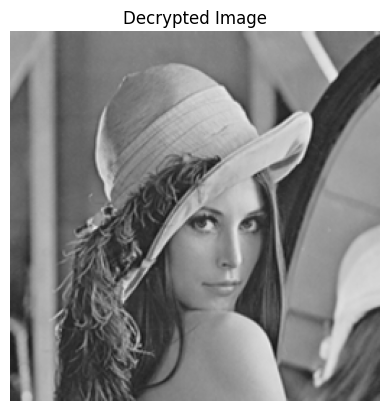

In [5]:
# Quick test to check if the encryption and decryption work
# Decrypt the image using the inverse randomizer equation
decrypted_image = np.zeros_like(encrypted_image, dtype=np.uint32)
for i in range(encrypted_image.shape[0]):
    for j in range(encrypted_image.shape[1]):
        decrypted_image[i, j] = inverse_randomizer(encrypted_image[i, j], A_inv, b, c, d, i, j, N)

# Convert back to an image
new_image_decrypted = Image.fromarray(decrypted_image.astype(np.uint32))

# Plotting decrypted image
plt.imshow(new_image_decrypted, cmap='gray')
plt.axis('off')
plt.title('Decrypted Image')
plt.show()

### Hiding the coeffecients of the inverse_randomizer function in a polynomial graph

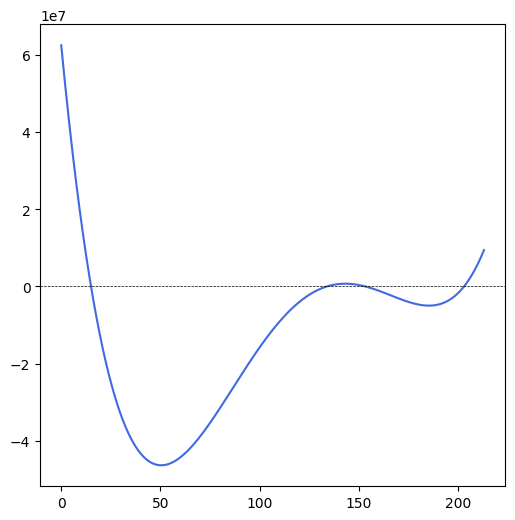

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define a continuous range of x values
x = np.linspace(0, max(A_inv, b, c, d) + 10, 1000)

# Define the polynomial function f(x) = (x - A)(x - B)(x - C)(x - D)
f = (x - A_inv) * (x - b) * (x - c) * (x - d)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(x, f, label='f(x) = (x - A)(x - B)(x - C)(x - D)', color='royalblue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
# plt.axvline(A_inv, color='red', linestyle='--', label=f'x = {A_inv}')
# plt.axvline(b, color='green', linestyle='--', label=f'x = {b}')
# plt.axvline(c, color='orange', linestyle='--', label=f'x = {c}')
# plt.axvline(d, color='purple', linestyle='--', label=f'x = {d}')
plt.savefig('polynomial_plot.png', dpi=300, bbox_inches='tight')
plt.show()

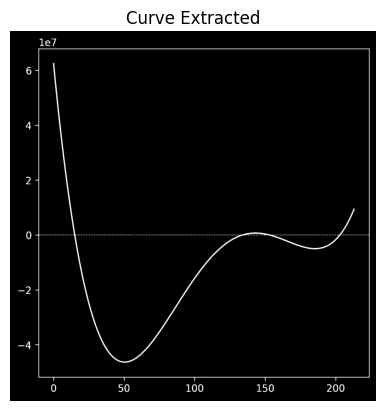

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (grayscale for processing)
img = cv2.imread("polynomial_plot.png", cv2.IMREAD_GRAYSCALE)

# Invert image so that the blue curve becomes white (for easy contour detection)
img_inverted = cv2.bitwise_not(img)

# Optional: apply Gaussian blur to remove noise
blurred = cv2.GaussianBlur(img_inverted, (3, 3), 0)

# Threshold the image to get binary curve
_, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY)

# Show the processed image
plt.imshow(binary, cmap='gray')
plt.title("Curve Extracted")
plt.axis('off')
plt.show()


Point: x = 0.948, y = -90539380.336
Point: x = 25.958, y = -3958944.284
Point: x = 46.317, y = 8398125.974
Point: x = 58.673, y = 1661606.102
Point: x = 105.528, y = -759281.116
Point: x = 134.391, y = 5663495.309
Point: x = 165.613, y = -3815150.940
Point: x = 176.245, y = -1696563.145
Point: x = 178.368, y = 5476446.773
Point: x = 208.710, y = 6996964.569


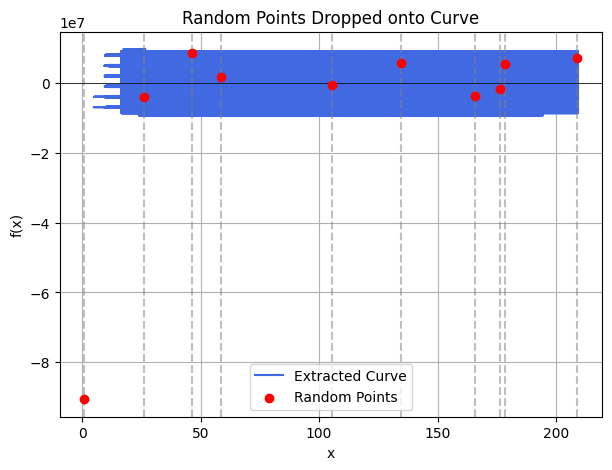

In [ ]:
#  find a white horizontal line near the center of the image and find x-crossings of the curve on it

ModuleNotFoundError: No module named 'sympy'

d:\Major Proj\Code\myenv\Lib\site-packages\scipy\interpolate\_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Approximate roots from image: []


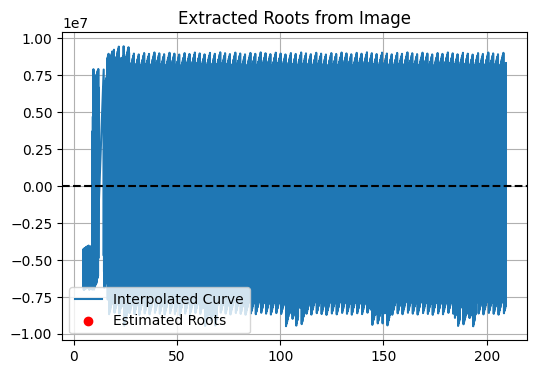